In [1]:
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import numpy as np
import matplotlib.colors as colors
from scipy.interpolate import make_interp_spline
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import convolve
import matplotlib.patches as patches
import netCDF4

In [25]:
df24 = pd.read_csv('/pampa/cloutier/etc24_consec.csv')

# open netcdf mask file
file = '/pampa/picart/Masks/mask_GEM5_ERA5grid'
data = xr.open_dataset(file)

# export netcdf to dataframe
mask = data.to_dataframe()

# drop index lat lon, but keep columns
mask = mask.reset_index()

# keep in mask values where HU = true
maskT = mask.loc[mask.HU != False]

## Create 2020 etc map

### Trying to recreate /home/chen/codes/plots_for_storm_tracks/individual_storm_track_120.py

#### Get grid points that define the border of CRCM6 domain

In [5]:
# Define the radius of neighboring grid points to consider
radius = 0.25

# Initialize an empty list to store the filtered grid points
filtered_points = []

# Iterate through each grid point in the dataframe
for i, row in mask.iterrows():
    if row['HU'] == True:
        lat = row['lat']
        lon = row['lon']

        # Find the neighboring grid points within the specified radius
        neighbors = mask[
            (mask['lat'] >= lat - radius) & (mask['lat'] <= lat + radius) &
            (mask['lon'] >= lon - radius) & (mask['lon'] <= lon + radius)
        ]

        # Check if there is at least one false 'HU' value in the neighbors
        if neighbors['HU'].isin([False]).any():
            filtered_points.append(row)

# Create a new dataframe with the filtered grid points
filtered_mask = pd.DataFrame(filtered_points)

#filtered_mask.to_csv('/pampa/cloutier/outline_crcm6_domain.csv')

In [3]:
# Domaine de NNA 
DomChen=netCDF4.Dataset('/home/chen/codes/2p5kmDomain/var_MG_free_grid_date.nc3','r')
Dom = netCDF4.Dataset('/pampa/picart/Masks/mask_GEM5_ERA5grid', 'r')

In [6]:
latChen = DomChen.variables['lat'][:,:]
lonChen = DomChen.variables['lon'][:,:]

latD = filtered_mask['lat'].tolist()
lonD = filtered_mask['lon'].tolist()

In [2]:
def lambert_map(extent=(-82, -75, 41, 46), cent_lon =-80,figsize=(14, 12), fig = None, ax = None):

    proj = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=35,
                                 standard_parallels=[35])
    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1, projection=proj)
        

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none', zorder=15)
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.9')
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='None',
                                            facecolor=[(0.59375 , 0.71484375, 0.8828125)])
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='dimgray',
                                            facecolor='None',lw=1.2)
    #(0.59375 , 0.71484375, 0.8828125)
    ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='dimgray', facecolor='none', zorder=10))
    ax.add_feature(land_50m,edgecolor='dimgray');
    #ax.add_feature(lakes_50m, zorder=3);
    ax.add_feature(lakes_50m_edge, zorder=10);
    #ax.add_feature(cfeature.LAKES, edgecolor='dimgray', zorder=10);
    ax.add_feature(cfeature.BORDERS, zorder=10,edgecolor='dimgray');
    #ax.add_feature(states_provinces, edgecolor='dimgray', zorder=10)
    ax.coastlines('50m', zorder=15, color='dimgray',lw=1.2)
    # Set plot bounds
    ax.set_extent(extent)
    return fig, ax

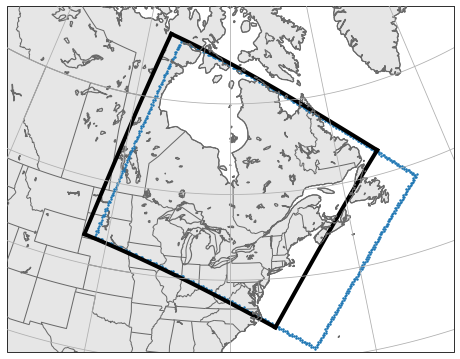

In [18]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np                         
import matplotlib.pyplot as plt           
import matplotlib.colors as colors
from matplotlib.path import Path
import matplotlib.patches as patches

def get_verts_new(categ_box):
    verts = [(categ_box['west'], categ_box['south']),
     (categ_box['west'], categ_box['north']),
     (categ_box['east'], categ_box['north']),
     (categ_box['east'], categ_box['south']),
     (0., 0.)]
    return verts

fig, ax = lambert_map(extent=(-110, -50, 27.5, 67.3), figsize=(8,10))

cf2=plt.plot(lonChen[0,:],latChen[0,:],c='black', lw=4,transform=ccrs.PlateCarree(),zorder=15)
cf2=plt.plot(lonChen[:,0],latChen[:,0],c='black',lw=4,transform=ccrs.PlateCarree(),zorder=15)
cf2=plt.plot(lonChen[-1,:],latChen[-1,:],c='black',lw=4,transform=ccrs.PlateCarree(),zorder=15)
cf2=plt.plot(lonChen[:,-1],latChen[:,-1],c='black',lw=4,transform=ccrs.PlateCarree(),zorder=15)

bnd=plt.scatter(lonD, latD, zorder=15, transform=ccrs.PlateCarree(), s=2)

ax.gridlines(zorder=21)

plt.savefig('/pampa/cloutier/fig/comp_dom_chen_crcm6.png', dpi=300)

plt.show()

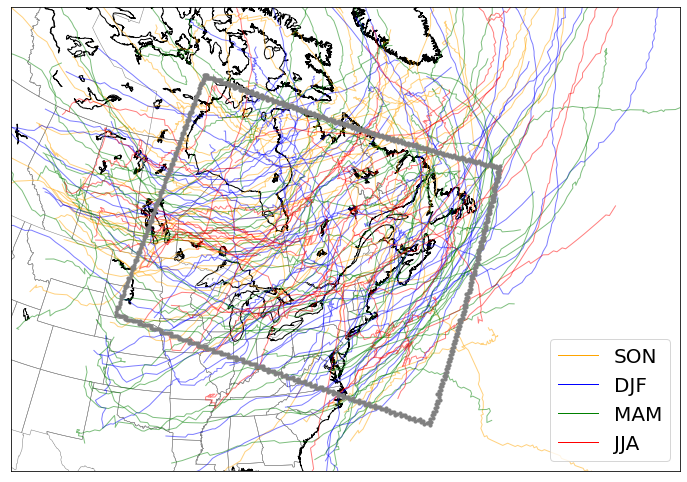

<Figure size 432x288 with 0 Axes>

In [217]:
# Create the Basemap object
from matplotlib.lines import Line2D

m = Basemap(llcrnrlon=-109, llcrnrlat=28, urcrnrlon=-15, urcrnrlat=45, 
            resolution='i', lat_0=60, lon_0=-90, area_thresh=1500., projection='lcc')

fig = plt.figure(figsize=(12, 9))

# Draw the coastline, countries, and states
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Define a list of dataframes and colors for each season
dataframes = [son20, djf20, mam20, jja20]
colors = ['orange', 'blue', 'green', 'red']
labels = ['SON',  'DJF', 'MAM', 'JJA']

#Iterate over each dataframe and its corresponding color
for df, color in zip(dataframes, colors):
    # Iterate over each storm in the current dataframe
    for storm_id, storm_data in df.groupby('storm'):
        # Convert latitude and longitude to map projection coordinates
        lat = storm_data['latitude'].tolist()
        lon = storm_data['longitude'].tolist()
        x, y = m(lon, lat)
        
        # Plot the line for the current storm with the corresponding color
        m.plot(x, y, color=color, linewidth=1, alpha=0.5)

        
lat = filtered_mask['lat'].tolist()
lon = filtered_mask['lon'].tolist()
x, y = m(lon, lat)
m.scatter(x, y, color='gray', s=10, alpha=1, zorder=3)

#Create a custom legend outside the loop
legend_elements = [Line2D([0], [0], color='orange', linewidth=1, label='SON'),
                   Line2D([0], [0], color='blue', linewidth=1, label='DJF'),
                   Line2D([0], [0], color='green', linewidth=1, label='MAM'),
                   Line2D([0], [0], color='red', linewidth=1, label='JJA')]

#Add the legend to the plot
plt.legend(handles=legend_elements, loc='lower right', fontsize="20")

plt.show()
#plt.savefig('/pampa/cloutier/tracks_2020.png')


### filtered storm tracks

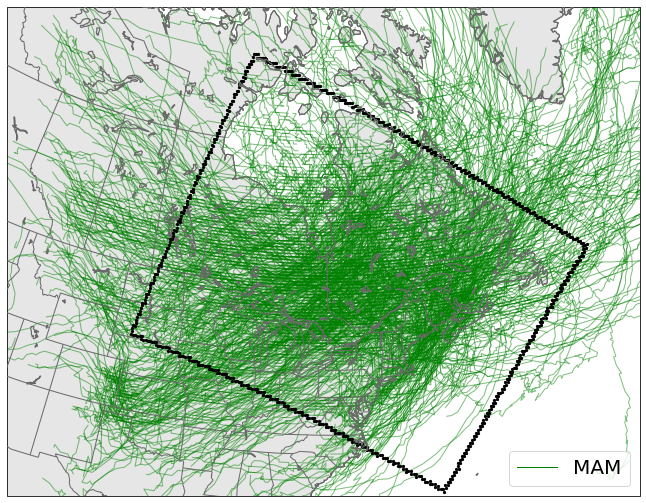

In [86]:
# filtered storm tracks 
# Create the Basemap object
from matplotlib.lines import Line2D

df = pd.read_csv('/pampa/cloutier/etc24_consec_v4.csv')
df_mam = df.loc[(df.season == 'MAM')]

fig, ax = lambert_map(extent=(-110, -50, 27.5, 67.3), figsize=(12,9))

# Define a list of dataframes and colors for each season
#seasons = ["DJF", "MAM", "JJA", "SON"]
seasons = ["MAM"]
#colors = ['orange', 'blue', 'green', 'red']
colors = ['green']
#seasons = ["DJF", "MAM", "JJA", "SON"]

# #Iterate over each dataframe and its corresponding color
# for season, color in zip(seasons, colors):
#     df = df24.loc[df24.season == season]
#     # Iterate over each storm in the current dataframe

# for storm_id, storm_data in df_mam.groupby('storm') :
#     # Convert latitude and longitude to map projection coordinates
#     lat = storm_data['latitude'].tolist()
#     lon = storm_data['longitude'].tolist()

#     # Plot the line for the current storm with the corresponding color
#     plt.plot(lat, lon, color=color, linewidth=1, alpha=0.5, transform=ccrs.PlateCarree())
        
    
for storm_id, storm in df_mam.groupby('storm') :
    # Convert latitude and longitude to map projection coordinates
    lat = storm['latitude'].tolist()
    lon = storm['longitude'].tolist()

    # Plot the line for the current storm with the corresponding color
    ax.plot(lon, lat, color=color, linewidth=1, transform=ccrs.PlateCarree(), alpha=0.5)

latD = filtered_mask['lat'].tolist()
lonD = filtered_mask['lon'].tolist()

bnd=ax.scatter(lonD, latD, zorder=15, transform=ccrs.PlateCarree(), s=5, color='black')

#Create a custom legend outside the loop
# legend_elements = [Line2D([0], [0], color='orange', linewidth=1, label='SON'),
#                    Line2D([0], [0], color='blue', linewidth=1, label='DJF'),
#                    Line2D([0], [0], color='green', linewidth=1, label='MAM'),
#                    Line2D([0], [0], color='red', linewidth=1, label='JJA')]

legend_elements = [Line2D([0], [0], color='green', linewidth=1, label='MAM')]

#Add the legend to the plot
plt.legend(handles=legend_elements, loc='lower right', fontsize="20")

plt.savefig('/pampa/cloutier/fig/filtered_tracks_mam.png', dpi=300)

plt.show()


### PLOT DENSITY

In [ ]:
# color palette

# 1 - 2   : F9FBCC
# 2 - 3   : E6F5B3
# 3 - 4   : C8E9B3
# 4 - 5   : 8ED4BA
# 5 - 6   : 57BFC1
# 6 - 7   : 32A8C5
# 7 - 8   : 1F85BC
# 8 - 9   : 225DA6
# 9 - 10  : 263A99
# 10 - 11 : 12276E
# 11 +    : 041D5D


### Carte avec test_densite_mam.csv, soit la densité moyennée sur 250km
### (ANCIEN DF AVEC 6636 TEMPÊTES)

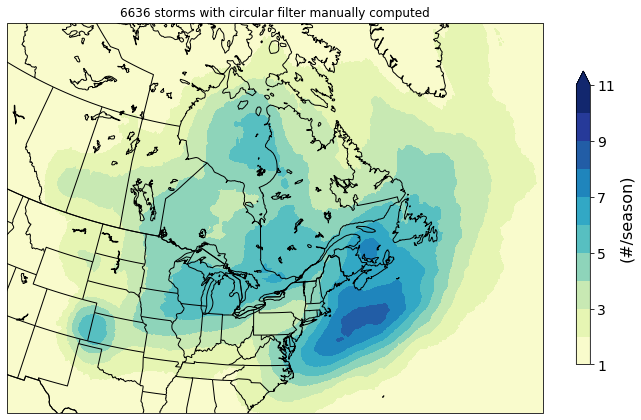

In [171]:
## ANCIEN PLOT AVEC LES 6636 TEMPÊTES
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap

# Load the CSV file
data1 = pd.read_csv('/pampa/cloutier/test_densite_mam.csv')

# Extract the necessary columns
lat = data1['lat']
lon = data1['lon']
storms = data1['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y), method='nearest')

# Create a figure and axes for the map
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
    central_longitude=-80, central_latitude=51)})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', 
                                   scale='50m', edgecolor='black', facecolor='none'))
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none'))

# Filter lakes based on area threshold
lakes = NaturalEarthFeature(category='physical', name='lakes', scale='50m')
filtered_lakes = cfeature.ShapelyFeature([geom for geom in lakes.geometries() if geom.area >= 0.1],
                                         ccrs.PlateCarree(), edgecolor='none')
ax.add_feature(filtered_lakes, edgecolor='black', facecolor='none')

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_interp, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree())

# Add a colorbar for the legend
# Set map boundaries and add a title
lat_min = 31.7
lat_max = 67.4
lon_min = 249.5
lon_max = 315
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.title('6636 storms with circular filter manually computed')
plt.show()
#plt.savefig('/pampa/cloutier/density_map_test_mam.png')

### Test avec etc_vort_den.csv, soit la densité à chaque point de grille

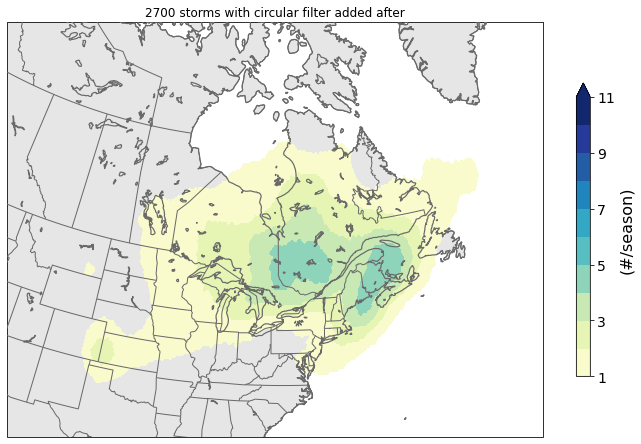

In [112]:
# AVEC LES 2700
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import convolve

# Load the CSV file avec la densité à chaque point de grille
data = pd.read_csv('/pampa/cloutier/etc24_den_with_etc24_consec_v4.csv')
data = data.loc[data.season=='MAM']

# Extract the necessary columns
lat = data['latitude']
lon = data['longitude']
storms = data['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y),method='nearest')

# Create a figure and axes for the map
#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
#    central_longitude=-80, central_latitude=51)})

fig, ax = lambert_map(extent=(-110, -50, 27.5, 67.3), figsize=(12,9))

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Apply Gaussian filter with a 250km radius
# knowing that 1° = 111km approx, 250 km is about 2.25°
# which is 2.25 / 0.25 = approx. 9 grid points

sigma = 9 # Adjust the sigma value based on your desired level of smoothing
#storms_smoothed = gaussian_filter(storms_interp, sigma=sigma)
#storms_smoothed = uniform_filter(storms_interp, size=sigma)
radius = 2
def circular_kernel(radius):
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    kernel[~mask] = 0
    return kernel

def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def circular_uniform_filter(array, radius):
    kernel = circular_kernel(radius)
    normalized_kernel = normalize_kernel(kernel)
    return convolve(array, normalized_kernel)

radius = 9
storms_circ = circular_uniform_filter(storms_interp, radius)

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_circ, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree(), zorder=9)

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.title('2700 storms with circular filter added after')

plt.savefig('/pampa/cloutier/fig/den_with_filter_mam.png', dpi = 300, facecolor='white')
plt.show()

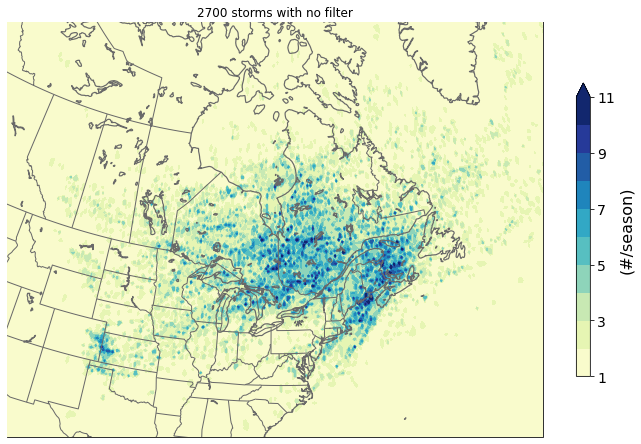

In [111]:
# AVEC LES 2700 TEMPÊTES
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import convolve

# Load the CSV file avec la densité à chaque point de grille
data = pd.read_csv('/pampa/cloutier/etc24_den_with_etc24_consec_v4.csv')
data = data.loc[data.season=='MAM']

# Extract the necessary columns
lat = data['latitude']
lon = data['longitude']
storms = data['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y),method='nearest')

# Create a figure and axes for the map
fig, ax = lambert_map(extent=(-110, -50, 27.5, 67.3), figsize=(12,9))

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_interp, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree(), zorder=9)

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.title('2700 storms with no filter')

plt.savefig('/pampa/cloutier/fig/density_scatter_mam.png', dpi=300, facecolor='white')
plt.show()

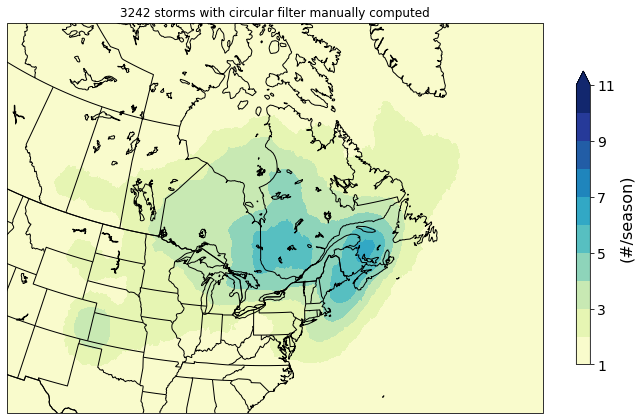

In [169]:
## AVEC LES 3242 TEMPÊTES
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap

# Load the CSV file de densité moyennée sur le rayon de 250km
data1 = pd.read_csv('/pampa/cloutier/test_densite_mam_v2.csv')

# Extract the necessary columns
lat = data1['lat']
lon = data1['lon']
storms = data1['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y), method='nearest')

# Create a figure and axes for the map
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
    central_longitude=-80, central_latitude=51)})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', 
                                   scale='50m', edgecolor='black', facecolor='none'))
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none'))

# Filter lakes based on area threshold
lakes = NaturalEarthFeature(category='physical', name='lakes', scale='50m')
filtered_lakes = cfeature.ShapelyFeature([geom for geom in lakes.geometries() if geom.area >= 0.1],
                                         ccrs.PlateCarree(), edgecolor='none')
ax.add_feature(filtered_lakes, edgecolor='black', facecolor='none')

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_interp, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree())

# Add a colorbar for the legend
# Set map boundaries and add a title
lat_min = 31.7
lat_max = 67.4
lon_min = 249.5
lon_max = 315
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.title('3200 storms with circular filter manually computed')
plt.show()
#plt.savefig('/pampa/cloutier/density_map_test_mam.png')

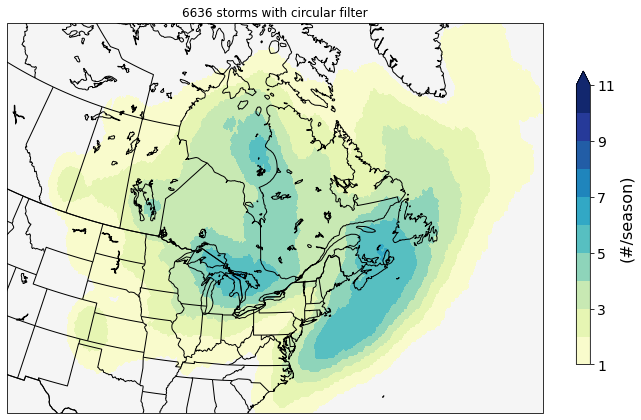

In [168]:
# AVEC LES 6636 tempêtes
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import convolve

# Load the CSV file avec la densité à chaque point de grille
data = pd.read_csv('/pampa/cloutier/etc24_den_6636.csv')
#data = data.loc[data.season=='MAM']

# Extract the necessary columns
lat = data['latitude']
lon = data['longitude']
storms = data['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y),method='nearest')

# Create a figure and axes for the map
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
    central_longitude=-80, central_latitude=51)})


# Add map features
ax.add_feature(cfeature.LAND,facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='whitesmoke')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', 
                                   scale='50m', edgecolor='black', facecolor='none'))
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none'))

# Filter lakes based on area threshold
lakes = NaturalEarthFeature(category='physical', name='lakes', scale='50m')
filtered_lakes = cfeature.ShapelyFeature([geom for geom in lakes.geometries() if geom.area >= 0.1],
                                         ccrs.PlateCarree(), edgecolor='none')
ax.add_feature(filtered_lakes, edgecolor='black', facecolor='none')

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Apply Gaussian filter with a 250km radius
# knowing that 1° = 111km approx, 250 km is about 2.25°
# which is 2.25 / 0.25 = approx. 9 grid points

sigma = 9 # Adjust the sigma value based on your desired level of smoothing
#storms_smoothed = gaussian_filter(storms_interp, sigma=sigma)
#storms_smoothed = uniform_filter(storms_interp, size=sigma)
radius = 9
def circular_kernel(radius):
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    kernel[~mask] = 0
    return kernel

def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def circular_uniform_filter(array, radius):
    kernel = circular_kernel(radius)
    normalized_kernel = normalize_kernel(kernel)
    return convolve(array, normalized_kernel)

radius = 9
storms_circ = circular_uniform_filter(storms_interp, radius)

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_circ, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree())

# Add a colorbar for the legend
# Set map boundaries and add a title
lat_min = 31.7
lat_max = 67.4
lon_min = 249.5
lon_max = 315
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.title('6636 storms with circular filter')
plt.show()

## CARTE DE DENSITÉ AVEC FICHIER NETCDF
### Le fichier contient la densité des etc filtrés autour d'un rayon de 250km

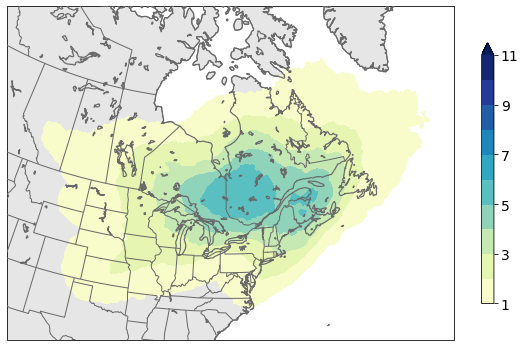

In [15]:
def get_verts_new(categ_box):
    verts = [(categ_box['west'], categ_box['south']),
     (categ_box['west'], categ_box['north']),
     (categ_box['east'], categ_box['north']),
     (categ_box['east'], categ_box['south']),
     (0., 0.)]
    return verts

box = {'west':-180, 'east':0, 'north':90, 'south':20}

Track=netCDF4.Dataset('/pampa/cloutier/filtered_track_density_1979_2020_all_seasons_250km.nc','r')
season='MAM'
lat0 = Track.variables['latitude'][:]
lon0 = Track.variables['longitude'][:]
den = Track.variables['trackDen_'+season+''][:,:]*1./42.
lon, lat = np.meshgrid(lon0, lat0)

plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['hatch.color'] = 'crimson'
fig, ax = lambert_map(extent=(-110, -48, 27.5, 67), figsize=(10,8))

cf = ax.contourf(lon, lat, den, transform=ccrs.PlateCarree(), zorder=6,cmap=plt.cm.get_cmap('YlGnBu'),
                 levels=np.arange(1,12,1), extend='max')

cb = plt.colorbar(cf, shrink=0.6) #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=14)

plt.savefig('/pampa/cloutier/fig/fig1_mam_filtered.png', dpi=300)
plt.show()

## CARTE DE DENSITÉ AVEC FICHIER NETCDF
### Le fichier contient la densité des etc filtrés autour d'un rayon de 250km

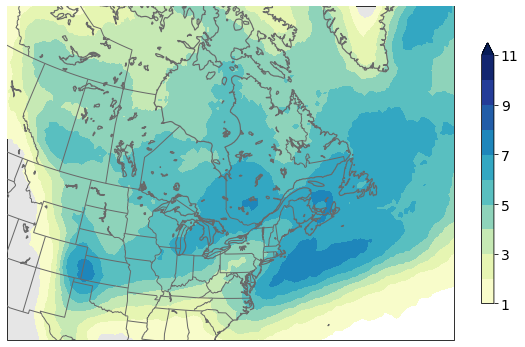

In [20]:
def get_verts_new(categ_box):
    verts = [(categ_box['west'], categ_box['south']),
     (categ_box['west'], categ_box['north']),
     (categ_box['east'], categ_box['north']),
     (categ_box['east'], categ_box['south']),
     (0., 0.)]
    return verts

box = {'west':-180, 'east':0, 'north':90, 'south':20}

Track=netCDF4.Dataset('/pampa/cloutier/Track_density_1979_2020_all_seasons_250km.nc','r')
season='MAM'
lat0 = Track.variables['latitude'][:]
lon0 = Track.variables['longitude'][:]
den = Track.variables['trackDen_'+season+''][:,:]*1./42.
lon, lat = np.meshgrid(lon0, lat0)

plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['hatch.color'] = 'crimson'
fig, ax = lambert_map(extent=(-110, -48, 27.5, 67), figsize=(10,8))

cf = ax.contourf(lon, lat, den, transform=ccrs.PlateCarree(), zorder=6,cmap=plt.cm.get_cmap('YlGnBu'),
                 levels=np.arange(1,12,1), extend='max')

cb = plt.colorbar(cf, shrink=0.6) #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=14)

plt.savefig('/pampa/cloutier/fig/fig1_mam_all.png', dpi=300)
plt.show()